# Importing Stuff

In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

# Setting constants

In [23]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

# Creating tf.dataset

In [24]:
corn_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\College Stuff\TY\ML\MP\Dataset\Corn",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3852 files belonging to 4 classes.


In [25]:
class_names = corn_dataset.class_names
class_names

['Cercospora_leaf_spot', 'Common_rust', 'Healthy', 'Northern_Leaf_Blight']

In [26]:
len(corn_dataset)

121

In [27]:
for image_batch, labels_batch in corn_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 3 1 3 3 3 3 2 3 1 0 3 0 1 3 2 1 2 0 2 2 1 3 3 2 2 1 0 1 3]


# Dataset Visualization

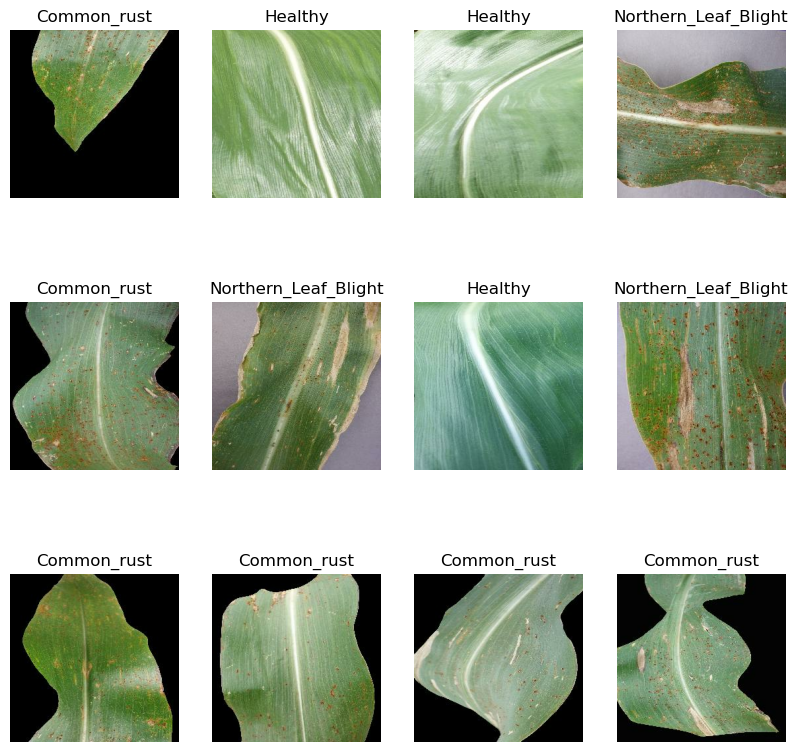

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in corn_dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Train-Test Split

In [29]:
len(corn_dataset)

121

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [31]:
corn_train, corn_val, corn_test = get_dataset_partitions_tf(corn_dataset)

In [32]:
len(corn_dataset), len(corn_train), len(corn_val), len(corn_test)

(121, 96, 12, 13)

### Cache Suffle Prefetch

In [33]:
train_ds = corn_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = corn_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = corn_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing, Rescaling

In [34]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
corn_train = corn_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [37]:
corn_train = corn_train.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model: CNN

In [38]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [39]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

### Compiling the model

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.99:
            print('The model has reached the accuracy desired (0.99), stop the training!')
            self.model.stop_training = True

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks = TrainingCallback()
)

Epoch 1/30
96/96 [==============================] - 182s 2s/step - loss: 0.7401 - accuracy: 0.6602 - val_loss: 0.3640 - val_accuracy: 0.8464
Epoch 2/30
96/96 [==============================] - 170s 2s/step - loss: 0.3212 - accuracy: 0.8610 - val_loss: 0.6114 - val_accuracy: 0.7708
Epoch 3/30
96/96 [==============================] - 184s 2s/step - loss: 0.2650 - accuracy: 0.8838 - val_loss: 0.2405 - val_accuracy: 0.8620
Epoch 4/30
96/96 [==============================] - 189s 2s/step - loss: 0.2259 - accuracy: 0.9023 - val_loss: 0.2657 - val_accuracy: 0.8932
Epoch 5/30
96/96 [==============================] - 153s 2s/step - loss: 0.2031 - accuracy: 0.9144 - val_loss: 0.5555 - val_accuracy: 0.7812
Epoch 6/30
96/96 [==============================] - 171s 2s/step - loss: 0.1751 - accuracy: 0.9287 - val_loss: 0.1653 - val_accuracy: 0.9323
Epoch 7/30
96/96 [==============================] - 155s 2s/step - loss: 0.1427 - accuracy: 0.9395 - val_loss: 0.1665 - val_accuracy: 0.9245
Epoch 8/30
96

In [43]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 9s 352ms/step - loss: 0.1821 - accuracy: 0.9545


In [44]:
scores

[0.18208850920200348, 0.9545454382896423]

Accuracy and Loss Curves

In [45]:
history

In [46]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 96}

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
epochs_trained = len(history.history['loss'])

In [49]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.7400785088539124,
 0.3211677372455597,
 0.26500967144966125,
 0.22590775787830353,
 0.20312154293060303]

In [50]:
for key in history.history:
    last_value = history.history[key][-1]
    print(key, ":", last_value)

loss : 0.021686824038624763
accuracy : 0.9928385615348816
val_loss : 0.195567324757576
val_accuracy : 0.9479166865348816


In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

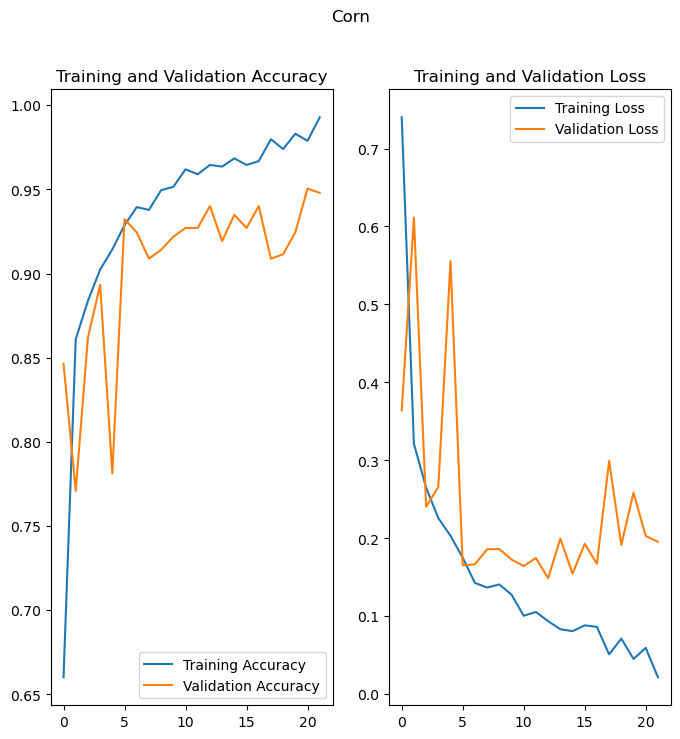

In [52]:
plt.figure(figsize=(8, 8))
plt.suptitle("Corn")
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy
1/1 [==============================] - 1s 721ms/step
predicted label: Healthy


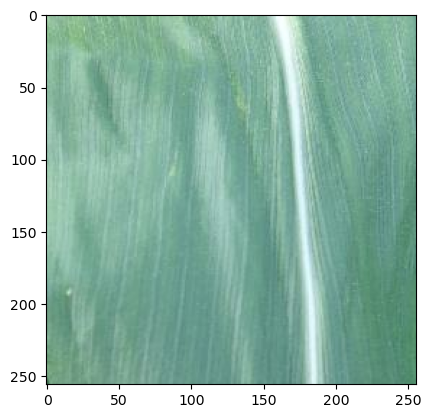

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


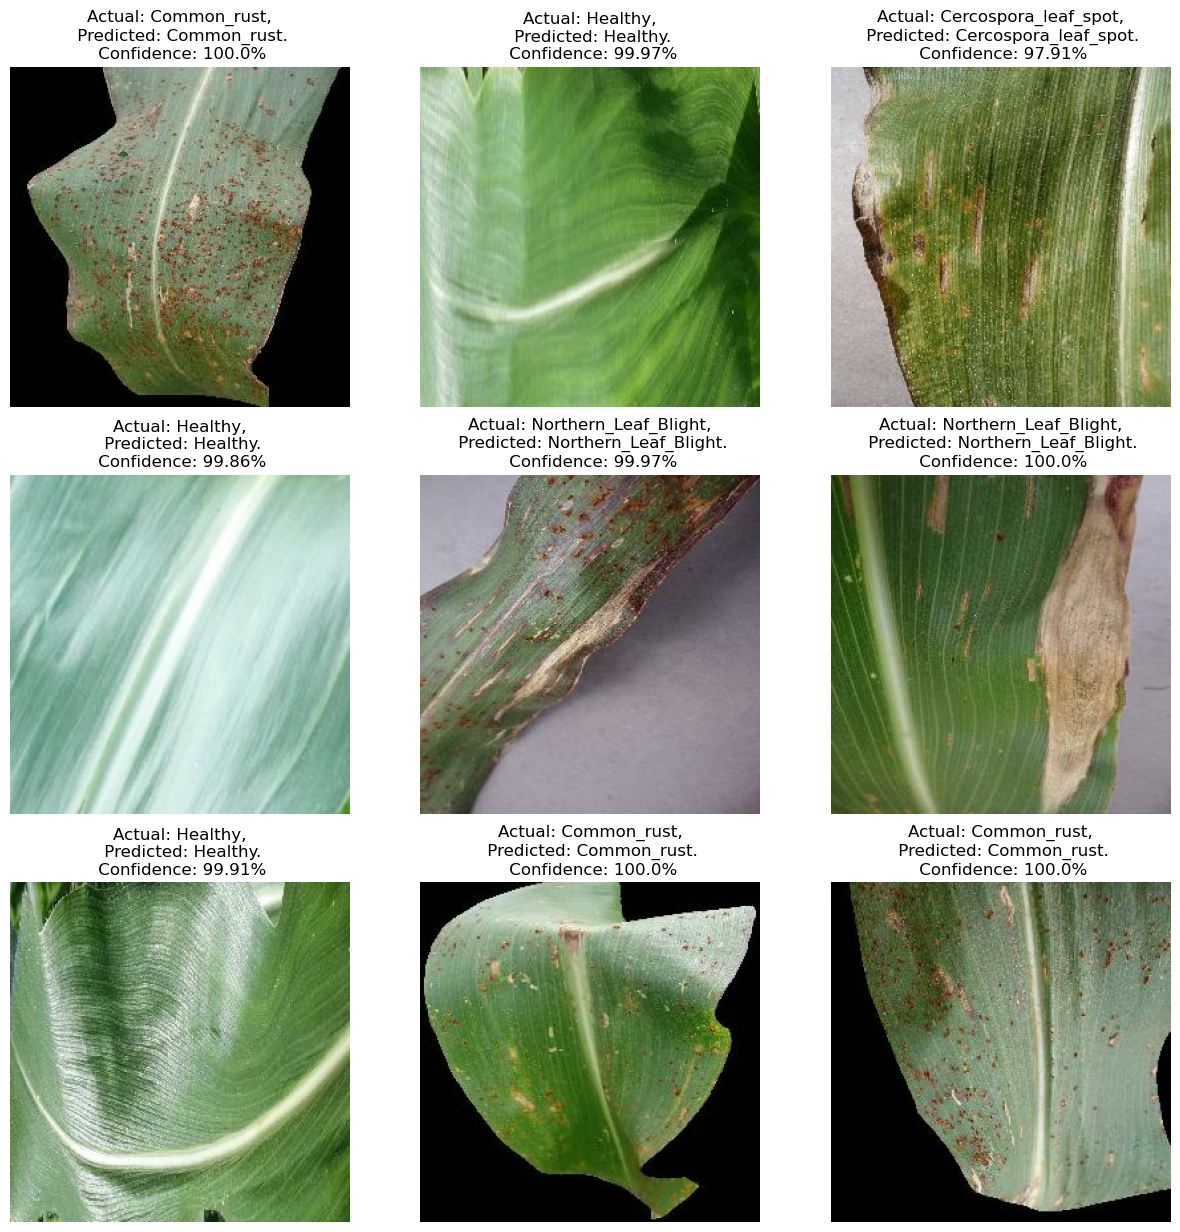

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
model.save(r'D:\College Stuff\TY\ML\MP\Main\Models\corn_cnn.h5')

In [57]:
import os
model.save("D:\College Stuff\TY\ML\MP\Main\Models\Corn")

INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Corn\assets


INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Corn\assets


In [58]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 331ms/step


In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 1.0, 'Corn')

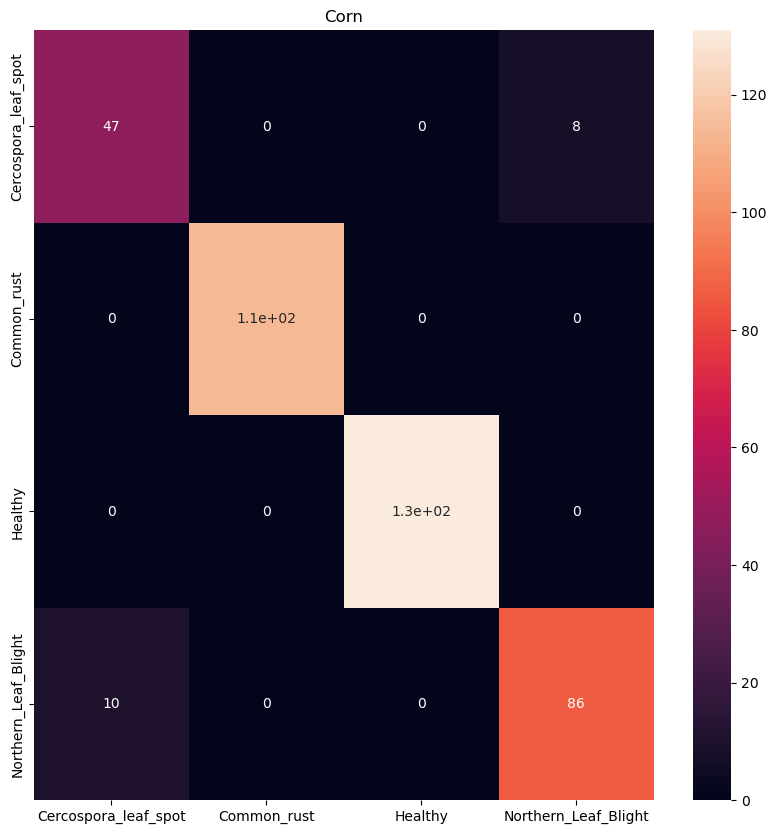

In [60]:
plt.figure(figsize=(10, 10))
corn_cm = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
graph_labels = ['Cercospora_leaf_spot', 'Common_rust', 'Healthy', 'Northern_Leaf_Blight']
sns.heatmap(corn_cm, annot = True, xticklabels=graph_labels, yticklabels=graph_labels)
plt.title("Corn")

In [61]:
corn_cm

array([[ 47,   0,   0,   8],
       [  0, 114,   0,   0],
       [  0,   0, 131,   0],
       [ 10,   0,   0,  86]], dtype=int64)

In [62]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [63]:
f1_val = f1_score(y_true=correct_labels, y_pred=predicted_labels, average = None)
print("F-1 Scores: ", f1_val)

F-1 Scores:  [0.83928571 1.         1.         0.90526316]
